# 10a -- K-means digits

...and color compression with an RGB image.

### Reading:

* [05.11 K Means](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb) (VanderPlas) -- github
* [Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) -- scikit-learn.org

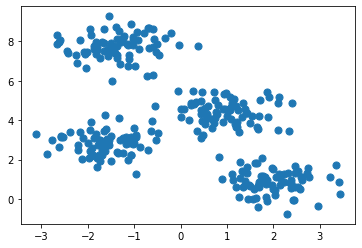

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

# K-means algorithm

K-Means minimizes a Euclidean distance metric: the within-cluster sum of squared errors (SSE), also called "cluster inertia":

$$
\text{SSE} = \text{cluster inertia}
 = \sum_{i=1}^N \sum_{k=1}^p w_{ij}||\mathbf{x_i - \mu_j}||^2
$$

**The Algorithm: Expectation-Maximization**

* Step 1: Guess some cluster centers
* Step 2: E-step -- Assign each data point to the nearest cluster center
* Step 3: M-step -- Redefine the cluster centers as the cluter means
  * Compute the SSE
  * If not converged, go to Step 2 and repeat

**Note**

* There is no guarantee of uniqueness -- final clusters can depend on first guess
* scikit-learn repeats with random first guesses (n_init=10 by default)

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

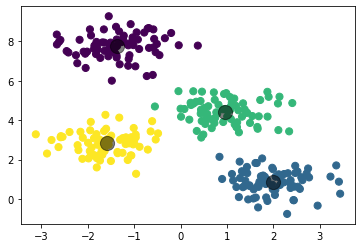

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Elbow method

* Unsupervised learning -- labels are unknown
* With K-Means, you must select the value of "K"
* Plot distortion (SSE) as a function of K and look for the "elbow"

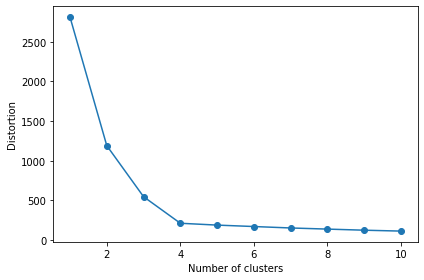

In [6]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

# Silhouette analysis

* Cluster cohesion, $c_i$, for sample "i":
$$
c_i = \text{average distance between sample i and other samples in the same cluster}
$$
* Cluster separation, $s_i$, for sample "i":
$$
s_i = \text{average distance between sample i and other samples in the nearest neighoring cluster}
$$
* Silhouette coefficient, $s_i$ measures cluster separation
$$
s_i = \frac{s_i - c_i}{\mathrm{max}(s_i, c_i)}
$$
  * $s_i$ is in the range [-1,1]
  * Optimal value $s_i = 1$ for cluster separation much greater than cohesion.
  * $s_i = 0$ when cluster cohesion and separation are the same
  * $s_i = -1$ when cluster cohesion is much larger than cluster separation (e.g., as might occur with an outlier)

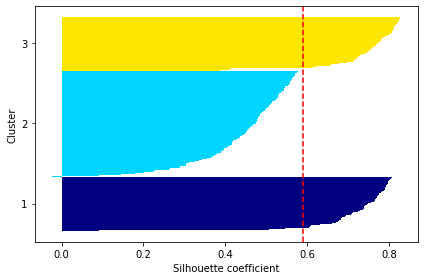

In [7]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

# K-means on digits

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [9]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

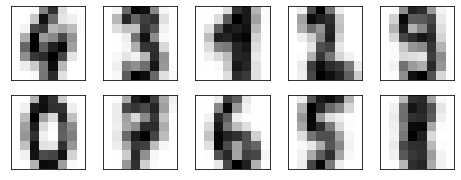

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

* We've identified some centers, but we don't know their labels.
* We'll assign labels based on the labels (this is cheating -- since we're using an unsupervised method).

In [11]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

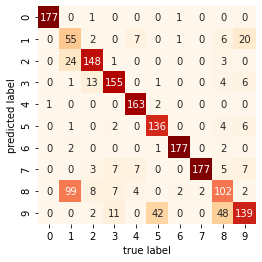

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', 
            cmap = "OrRd", cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Pre-processing with t-SNE

* Recall, [digits with naive Bayes](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb) has an accuracy of 83%
* Pre-processing with t-SNE (unsupervised) performs significantly better
* Pre-processing with PCA degrades performance

In [14]:
# This improves accuracy
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

In [15]:
# Pre-processing with PCA -- degrades accuracy
from sklearn.decomposition import PCA

digits_proj = PCA(n_components=2).fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.6071229827490262

# K-means for color compression

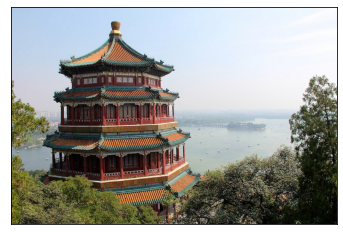

In [27]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

This image is 426-by-640 pixels.

In [18]:
china.shape

(427, 640, 3)

Each pixel has 3 colors -- [Red, Green, Blue] -- encoded from 0 to 255

In [31]:
# The origin is in the upper left corner
china[0, 0, :]

array([174, 201, 231], dtype=uint8)

In [44]:
# An image with one pixel
upper_left = china[:1,:1,:]
print('1-pixel image shape:', upper_left.shape)
upper_left

1-pixel image shape: (1, 1, 3)


array([[[174, 201, 231]]], dtype=uint8)

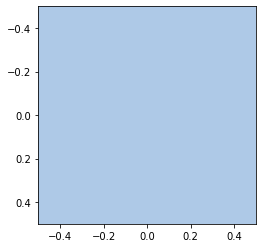

In [45]:
# Pixel in the upper left
plt.imshow(upper_left);

array([[[15, 24,  7]]], dtype=uint8)

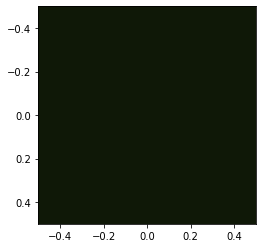

In [48]:
lower_right = china[426, 639, :]
lower_right = lower_right.reshape(1, 1, -1)
plt.imshow(lower_right);
lower_right

In [19]:
data = china / 255.0 # rescale values to [0...1]
data = data.reshape(427 * 640, 3) # convert to 1-D array of 3-color pixels
data.shape

(273280, 3)

In [20]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

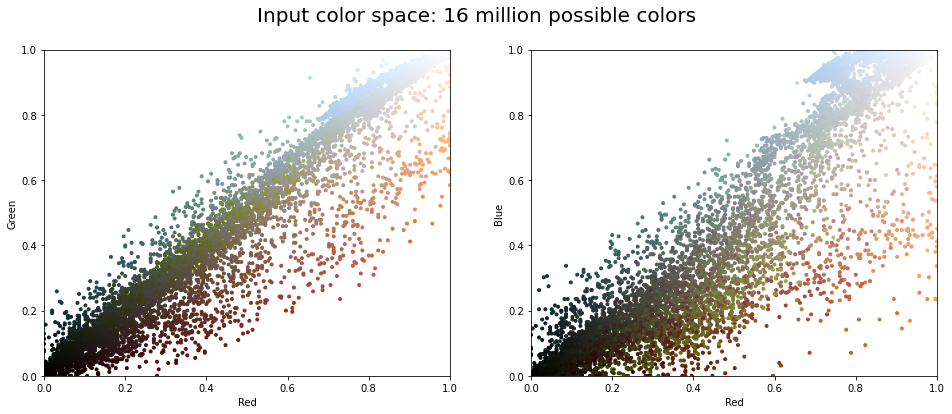

In [21]:
plot_pixels(data, title='Input color space: 16 million possible colors')

# Mini-batch K-means

Mini-batch calculation reduces run time with **almost** the same optimization criterion (see ref for comparison).

* Reference [sklearn.cluster.mini-batch-kmeans](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans) API reference -- scikit-learn.org

kmeans.cluster_centers_: (16, 3)
kmeans.cluster_centers_[0]: [0.58933586 0.62969375 0.61157077]
kmeans.cluster_centers_[[0,1]]:
 [[0.58933586 0.62969375 0.61157077]
 [0.05737686 0.05340123 0.0301351 ]]
kmeans.cluster_centers_[[0,1]].shape: (2, 3)
new_colors.shape: (273280, 3)


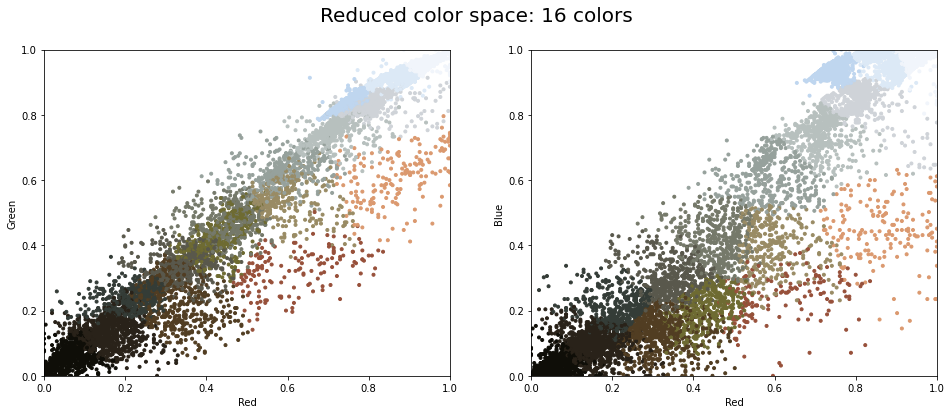

In [62]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
kmeans = MiniBatchKMeans(16)
#kmeans = KMeans(16)
kmeans.fit(data)

new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Investigate what's going on with the image manipulation
print('kmeans.cluster_centers_:', kmeans.cluster_centers_.shape)
print('kmeans.cluster_centers_[0]:', kmeans.cluster_centers_[0])
print('kmeans.cluster_centers_[[0,1]]:\n', kmeans.cluster_centers_[[0,1]])
print('kmeans.cluster_centers_[[0,1]].shape:', kmeans.cluster_centers_[[0,1]].shape)
print('new_colors.shape:', new_colors.shape)

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

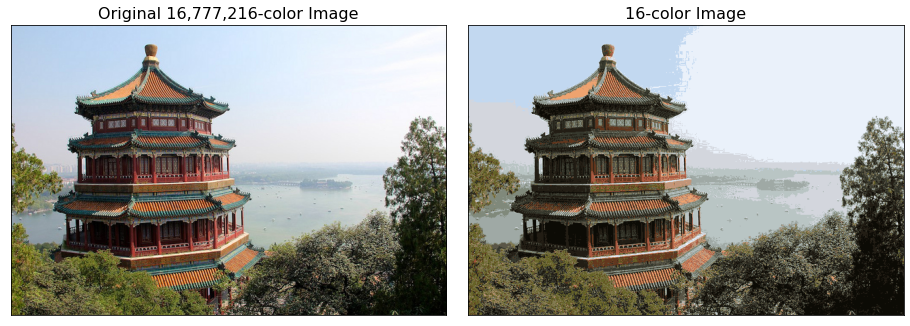

In [59]:
# Visualize the new_colors array compared to the original full-color image
china_recolored = new_colors.reshape(china.shape)

# Compute the number of colors in the original RGB 8-bit (256 shades) encoding
n = 256**3

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original {:,d}-color Image'.format(n), size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);